In [1]:
%%capture
!pip install scprep
!pip install anndata
!pip install scanpy

In [2]:
import numpy as np
import pandas as pd
import anndata
import scprep
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
import tempfile
import os
from os import path
import sys
import scipy
from scipy import sparse

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import load_raw
import normalize_tools as nm
import metrics

In [3]:
torch.cuda.is_available()

/home/jiayueg/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


False

# **try out with scicar cell lines dataset**

**1. URLs for raw data**

In [4]:
rna_data, atac_data, rna_cells, atac_cells, rna_genes, atac_genes = load_raw.load_raw_cell_lines()

In [5]:
scicar_data, joint_index, keep_cells_idx = load_raw.merge_data(rna_data, atac_data, rna_cells, atac_cells, rna_genes, atac_genes)
#rna_df, atac_df = ann2df(scica|r_data)|

In [6]:
def preprocess_vae(
    adata,
    hvg_rna_prop=0.6,
    hvg_atac_prop=0.3,
):
    #select highly variable genes respectively for RNA and ATAC modalities
    nm.log_cpm(adata)
    nm.log_cpm(adata, obsm = "mode2", obs = "mode2_obs", var = "mode2_var")
    nm.hvg_by_sc(adata, proportion = hvg_rna_prop)
    nm.hvg_by_sc(
        adata, 
        obsm = "mode2", 
        obs = "mode2_obs", 
        var = "mode2_var", 
        proportion = hvg_atac_prop,
    )
    adata.uns["mode2_obs"] = np.array(adata.uns["mode2_obs"][0])
    adata.uns["mode2_var"] = np.array(adata.uns["mode2_var"][0])
    dim_mode1 = adata.X.shape[1]
    dim_mode2 = adata.obsm["mode2"].shape[1]
    return adata, dim_mode1, dim_mode2

In [7]:
train_data_raw, test_data_raw, indices_train, mask_test = load_raw.train_test_split(scicar_data)
scicar_data_filtered, dim_rna, dim_atac = preprocess_vae(scicar_data)
train_data_filtered, test_data_filtered = load_raw.split_with_mask(scicar_data_filtered, indices_train, mask_test)

In [19]:
#set up all hyper-parameters
hyper = {
    "nEpochs":100,
    "dimRNA":dim_rna,
    "dimATAC":dim_atac,
    "layer_sizes":[1024, 512, 256],
    "nz":128,
    "batchSize":512,
    "lr":1e-3,
    "add_hinge":True,
    "lamb_hinge":10,
    "lamb_match":1,
    "lamb_nn":1.5,
    "lamb_kl":1e-9,
    "lamb_anc":1e-9,
    "clip_grad":0.1,
    "checkpoint_path": './checkpoint/vae_hinge.pt',
}

# **define pytorch datasets for RNA and ATAC**

In [20]:
class Merge_Dataset(Dataset):
    def __init__(self, adata_raw, adata_filtered):
        self.rna_data_filtered, self.atac_data_filtered = self._load_merge_data(adata_filtered)
        self.rna_data_raw = self._load_raw_ref_data(adata_raw)
        
    def __len__(self):
        #assert(len(self.rna_data) == len(self.atac_data))
        return len(self.atac_data_filtered)
  
    def __getitem__(self, idx):
        rna_filtered = self.rna_data_filtered.values[idx]
        atac_filtered = self.atac_data_filtered.values[idx]
        rna_raw = self.rna_data_raw.values[idx]
        #return a tensor that for a single observation
        return [
            torch.from_numpy(rna_filtered).float(),
            torch.from_numpy(atac_filtered).float(),
            torch.from_numpy(rna_raw).float(),
        ]
  
    def _load_merge_data(self, adata):
        rna_df = pd.DataFrame(
            data = adata.X.toarray(), 
            index = np.array(adata.obs.index), 
            columns = np.array(adata.var.index),
        )
        atac_df = pd.DataFrame(
            data = adata.obsm["mode2"].toarray(), 
            index = np.array(adata.uns["mode2_obs"]), 
            columns = np.array(adata.uns["mode2_var"]),
        )
        return rna_df, atac_df
    
    def _load_raw_ref_data(self, adata_raw):
        rna_df = pd.DataFrame(
            data = adata_raw.X.toarray(), 
            index = np.array(adata_raw.obs.index), 
            columns = np.array(adata_raw.var.index),
        )
        return rna_df

# **define basic models(autoencoders) for learning latent space**

In [21]:
class FC_VAE(nn.Module):
    def __init__(self, n_input, nz, layer_sizes=hyper["layer_sizes"]):
        super(FC_VAE, self).__init__()
        self.n_input = n_input
        self.nz = nz
        self.layer_sizes = layer_sizes

        self.encoder_layers = []

        self.encoder_layers.append(nn.Linear(n_input, self.layer_sizes[0]))
        self.encoder_layers.append(nn.LeakyReLU(inplace=True))
        self.encoder_layers.append(nn.BatchNorm1d(self.layer_sizes[0]))

        for layer_idx in range(len(layer_sizes)-1):
            if layer_idx == len(layer_sizes) - 2:
                self.encoder_layers.append(nn.Linear(self.layer_sizes[layer_idx], self.layer_sizes[layer_idx+1]))
                self.encoder_layers.append(nn.LeakyReLU(inplace=True))
            else:
                self.encoder_layers.append(nn.Linear(self.layer_sizes[layer_idx], self.layer_sizes[layer_idx+1]))
                self.encoder_layers.append(nn.BatchNorm1d(self.layer_sizes[layer_idx+1]))
                self.encoder_layers.append(nn.LeakyReLU(inplace=True))

        self.encoder = nn.Sequential(
            *self.encoder_layers
        )
        self.fc1 = nn.Linear(self.layer_sizes[-1], nz)
        self.fc2 = nn.Linear(self.layer_sizes[-1], nz)

        self.decoder_layers = []
        self.decoder_layers.append(nn.Linear(nz, self.layer_sizes[-1]))
        self.decoder_layers.append(nn.BatchNorm1d(self.layer_sizes[-1]))
        self.decoder_layers.append(nn.LeakyReLU(inplace=True))

        for layer_idx in range(len(self.layer_sizes)-1, 0, -1):
            self.decoder_layers.append(nn.Linear(self.layer_sizes[layer_idx], self.layer_sizes[layer_idx-1]))
            self.decoder_layers.append(nn.BatchNorm1d(self.layer_sizes[layer_idx-1]))
            self.decoder_layers.append(nn.LeakyReLU(inplace=True))

        self.decoder_layers.append(nn.Linear(self.layer_sizes[0], self.n_input))

        self.decoder = nn.Sequential(
            *self.decoder_layers
        )
    def encode(self, x):
        h = self.encoder(x)
        return self.fc1(h), self.fc2(h)

    def reparametrize(self, mu, logvar):
        #calculate std from log(var)
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, z, mu, logvar

    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z
    
    def generate(self, z):
        return self.decode(z)

# **train VAE model based on reconstruction, KL divergence, and anchor loss**

In [22]:
def collate_fn(batch):
    n_svd = 100
    proportion_neighbors = 0.1
    
    rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw = zip(*batch)
    rna_inputs_filtered = torch.stack(rna_inputs_filtered)
    atac_inputs_filtered = torch.stack(atac_inputs_filtered)
    rna_inputs_raw = torch.stack(rna_inputs_raw)
    
    n_svd = min([n_svd, min(rna_inputs_raw.shape) - 1])
    n_neighbors = int(np.ceil(proportion_neighbors * rna_inputs_raw.shape[0]))
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(rna_inputs_raw)
    _, indices_true = (
        sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X_pca).kneighbors(X_pca)
    )
    
    return rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw, torch.from_numpy(indices_true)

In [23]:
#load dataset and split train and test data
def get_data_loaders(train_data_filtered, test_data_filtered, train_data_raw, test_data_raw):
    train_set = Merge_Dataset(train_data_raw, train_data_filtered)
    test_set = Merge_Dataset(test_data_raw, test_data_filtered)
    #load data loader
    train_loader = DataLoader(
        train_set, 
        batch_size=hyper["batchSize"], 
        collate_fn=collate_fn, 
        drop_last=False, 
        shuffle=True
    )
    test_loader = DataLoader(
        test_set, 
        batch_size=test_data_filtered.shape[0], 
        collate_fn=collate_fn, 
        drop_last=False,
        shuffle=False
    )
    return train_loader, test_loader

In [24]:
class StructureHingeLoss(nn.Module):
    def __init__(self, margin, max_val, lamb_match, lamb_nn, device):
        super(StructureHingeLoss, self).__init__()
        self.margin = margin
        self.max_val = max_val
        self.lamb_match = lamb_match
        self.lamb_nn = lamb_nn
        self.device = device
        
    def forward(self, rna_outputs, atac_outputs, nn_indices):
        #rna_outputs: n_batch x n_latent
        #atac_outputs: n_batch x n_latent
        assert rna_outputs.shape[0] == atac_outputs.shape[0]
        assert rna_outputs.shape[1] == atac_outputs.shape[1]
        n_batch = rna_outputs.shape[0]
        
        #calculated pairwise L2 distance
        #dist_rna_atac[i][j]: the L2 distance between RNA embedding i
        #and ATAC embedding j (n_batch x n_batch)
        #constraint for ensuring every rna embedding is close to matched atac embedding
        dist_rna_atac = torch.cdist(rna_outputs, atac_outputs, p=2)
        match_labels = torch.eye(n_batch).to(self.device)
        match_mask = match_labels > 0
        pos_match_dist = torch.masked_select(dist_rna_atac, match_mask).view(n_batch, 1)
        neg_match_dist = torch.masked_select(dist_rna_atac, ~match_mask).view(n_batch, -1)
        
        loss_match_rna = torch.clamp(self.margin + pos_match_dist - neg_match_dist, 0, self.max_val)
        loss_match_rna = loss_match_rna.mean()
        #print(f"loss_match_rna: {loss_match_rna}")
        
        #constraint for ensuring every atac embedding is close to matched rna embedding
        dist_atac_rna = dist_rna_atac.t()
        pos_match_dist = torch.masked_select(dist_atac_rna, match_mask).view(n_batch, 1)
        neg_match_dist = torch.masked_select(dist_atac_rna, ~match_mask).view(n_batch, -1)
        
        loss_match_atac = torch.clamp(self.margin + pos_match_dist - neg_match_dist, 0, self.max_val)
        loss_match_atac = loss_match_rna.mean()
        #print(f"loss_match_atac: {loss_match_atac}")
        
        #constraint for ensuring that every RNA embedding is close to 
        #the neighboring RNA embeddings.
        nn_masked = torch.zeros(n_batch, n_batch).to(self.device)
        nn_masked.scatter_(1, nn_indices, 1.)
        nn_masked = nn_masked > 0
        
        dist_rna_rna = torch.cdist(rna_outputs, rna_outputs, p=2)
        
        #pos_rna_nn_dist: n_batch x n_neighbor
        pos_rna_nn_dist = torch.masked_select(dist_rna_rna, nn_masked).view(n_batch, -1)
        neg_rna_nn_dist = torch.masked_select(dist_rna_rna, ~nn_masked).view(n_batch, -1)
        rna_nn_loss = torch.clamp(self.margin + pos_rna_nn_dist[...,None] - neg_rna_nn_dist[..., None, :], 0, self.max_val)
        rna_nn_loss = rna_nn_loss.mean()
        #print(f"rna_nn_loss: {rna_nn_loss}")
        
        #constraint for ensuring that every ATAC embedding is close to 
        #the neighboring ATAC embeddings.
        dist_atac_atac = torch.cdist(atac_outputs, atac_outputs, p=2)
        #pos_rna_nn_dist: n_batch x n_neighbor
        pos_atac_nn_dist = torch.masked_select(dist_atac_atac, nn_masked).view(n_batch, -1)
        neg_atac_nn_dist = torch.masked_select(dist_atac_atac, ~nn_masked).view(n_batch, -1)
        atac_nn_loss = torch.clamp(self.margin + pos_atac_nn_dist[...,None] - neg_atac_nn_dist[..., None, :], 0, self.max_val)
        atac_nn_loss = atac_nn_loss.mean()
        #print(f"atac_nn_loss: {atac_nn_loss}")
        
        loss = (self.lamb_match * loss_match_rna 
                + self.lamb_match * loss_match_atac
                + self.lamb_nn * rna_nn_loss 
                + self.lamb_nn * atac_nn_loss)
        return loss

In [25]:
#set up loss function
def basic_loss(recon_x, x, mu, logvar, lamb1):
    MSE = nn.MSELoss()
    lloss = MSE(recon_x, x)
    #KL divergence
    KL_loss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    lloss = lloss + lamb1*KL_loss
    return lloss

#anchor loss for minimizing distance between paired observation
def anchor_loss(embed_rna, embed_atac):
    L1 = nn.L2Loss()
    anc_loss = L2(embed_rna, embed_atac)
    return anc_loss

def hinge_loss(
    margin, 
    max_val, 
    lamb_match,
    lamb_nn, 
    embed_rna, 
    embed_atac, 
    nn_indices,
):
    Hinge_Loss = StructureHingeLoss(margin, max_val, lamb_match, lamb_nn)
    loss = Hinge_Loss(embed_rna, embed_atac, nn_indices)
    return loss

In [26]:
def knn_criteria(rna_inputs, rna_outputs, atac_outputs, proportion_neighbors=0.1, n_svd=100):
    n_svd = min([n_svd, min(rna_inputs.shape)-1])
    n_neighbors = int(np.ceil(proportion_neighbors*rna_inputs.shape[0]))
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(rna_inputs)
    _, indices_true = (
        sklearn.neighbors.NearestNeighbors(n_neighbors = n_neighbors).fit(X_pca).kneighbors(X_pca)
    )
    _, indices_pred = (
        sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(rna_outputs).kneighbors(atac_outputs)
    )
    neighbors_match = np.zeros(n_neighbors, dtype=int)
    for i in range(rna_inputs.shape[0]):
        _, pred_matches, true_matches = np.intersect1d(
            indices_pred[i], indices_true[i], return_indices=True
        )
        neighbors_match_idx = np.maximum(pred_matches, true_matches)
        neighbors_match += np.sum(np.arange(n_neighbors) >= neighbors_match_idx[:, None], axis = 0,)
    neighbors_match_curve = neighbors_match/(np.arange(1, n_neighbors + 1) * rna_inputs.shape[0])
    area_under_curve = np.mean(neighbors_match_curve)
    return area_under_curve

In [33]:
#set up train functions
def main():
    #load training data and testing data
    train_loader, test_loader = get_data_loaders(
        train_data_filtered,
        test_data_filtered,
        train_data_raw,
        test_data_raw,
    )
    
    #load checkpoint
    checkpoint = None
    if path.exists(hyper["checkpoint_path"]):
        checkpoint = torch.load(hyper["checkpoint_path"])
    
    #load basic models
    netRNA = FC_VAE(n_input=hyper["dimRNA"], nz=hyper["nz"], layer_sizes=hyper["layer_sizes"])
    netATAC = FC_VAE(n_input=hyper["dimATAC"], nz=hyper["nz"], layer_sizes=hyper["layer_sizes"])
    if checkpoint != None:
        netRNA.load_state_dict(checkpoint["net_rna_state_dict"])
        netATAC.load_state_dict(checkpoint["net_atac_state_dict"])
        
    if torch.cuda.is_available():
        print("using GPU")
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    netRNA.to(device)
    netATAC.to(device)
    
    #setup optimizers for two nets
    opt_netRNA = optim.Adam(list(netRNA.parameters()), lr=hyper["lr"])
    opt_netATAC = optim.Adam(list(netATAC.parameters()), lr=hyper["lr"])
    scheduler_netRNA = optim.lr_scheduler.ReduceLROnPlateau(
        opt_netRNA,
        patience=10,
        threshold=0.01,
        threshold_mode="abs",
        min_lr=1e-5,
    )
    scheduler_netATAC = optim.lr_scheduler.ReduceLROnPlateau(
        opt_netATAC,
        patience=10,
        threshold=0.01,
        threshold_mode="abs",
        min_lr=1e-5,
    )
    
    best_knn_auc = 0
    if checkpoint != None:
        best_knn_auc = checkpoint["dev_acc"]
        
    #training
    for epoch in range(hyper["nEpochs"]):
        train_losses = []
        #train for epochs
        for idx, (rna_inputs_filtered, atac_inputs_filtered, rna_inputs_raw, nn_indices) in enumerate(train_loader):
            rna_inputs_filtered = Variable(rna_inputs_filtered).to(device)
            atac_inputs_filtered = Variable(atac_inputs_filtered).to(device)
            rna_inputs_raw = Variable(rna_inputs_raw).to(device)
            nn_indices = Variable(nn_indices).to(device)
            
            opt_netATAC.zero_grad()
            opt_netRNA.zero_grad()
            recon_rna, z_rna, mu_rna, logvar_rna = netRNA(rna_inputs_filtered)
            recon_atac, z_atac, mu_atac, logvar_atac = netATAC(atac_inputs_filtered)
            rna_loss = basic_loss(recon_rna, rna_inputs_filtered, mu_rna, logvar_rna, lamb1=hyper["lamb_kl"])
            atac_loss = basic_loss(recon_atac, atac_inputs_filtered, mu_atac, logvar_atac, lamb1=hyper["lamb_kl"])
            
            if hyper["add_hinge"]:
                hinge_loss = StructureHingeLoss(
                    margin=0.3, 
                    max_val=1e6, 
                    lamb_match=hyper["lamb_match"], 
                    lamb_nn=hyper["lamb_nn"],
                    device=device,
                )
                h_loss = hinge_loss(z_rna, z_atac, nn_indices)
            '''if epoch % 5 == 0:
                print(f"rna_loss: {rna_loss}")
                print(f"atac_loss:{atac_loss}")
                print(f"anc_loss: {anc_loss}")
                print(f"hinge loss: {h_loss}")'''

            #loss functions for each modalities
            train_loss = rna_loss + atac_loss + hyper["lamb_hinge"] * h_loss
            #train_loss = rna_loss + atac_loss
            #train_loss = rna_loss + atac_loss + hyper["lamb_anc"] * anc_loss
            #rain_loss = rna_loss + atac_loss + hyper["lamb_anc"] * anc_loss + h_loss
            train_loss.backward()
            nn.utils.clip_grad_norm_(netRNA.parameters(), max_norm=hyper["clip_grad"])
            nn.utils.clip_grad_norm_(netATAC.parameters(), max_norm=hyper["clip_grad"])
            opt_netRNA.step()
            opt_netATAC.step()
            train_losses.append(train_loss.item())
        avg_train_loss = np.mean(train_losses)
        if epoch % 5 == 0:
            print("Epoch: " + str(epoch) + ", train loss: " + str(avg_train_loss))
        
        #evaluating step
        with torch.no_grad():
            netRNA.eval()
            netATAC.eval()
            knn_acc = []
            for idx, samples in enumerate(test_loader):
                rna_inputs_filtered = samples[0].float().to(device)
                atac_inputs_filtered = samples[1].float().to(device)
                rna_inputs_raw = samples[2].float().to(device)

                _, output_rna, _, _ = netRNA(rna_inputs_filtered)
                _, output_atac, _, _ = netATAC(atac_inputs_filtered)
                knn_acc.append(knn_criteria(rna_inputs_raw.cpu().detach(), output_rna.cpu().detach(), output_atac.cpu().detach()))
            avg_knn_auc = np.mean(knn_acc)
            if avg_knn_auc > best_knn_auc:
                torch.save({
                    "epoch":epoch,
                    "lamb_match":hyper["lamb_match"],
                    "lamb_nn":hyper["lamb_nn"],
                    "lamb_hinge":hyper["lamb_hinge"],
                    "clip_grad":hyper['clip_grad'],
                    "layer_sizes":hyper['layer_sizes'],
                    "lr": hyper["lr"],
                    "net_rna_state_dict":netRNA.state_dict(),
                    "net_atac_state_dict":netATAC.state_dict(),
                    "train_loss":avg_train_loss,
                    "dev_acc":avg_knn_auc,
                }, hyper["checkpoint_path"])
                
        if epoch % 5 == 0:
            print("Epoch: " + str(epoch) + ", acc: " + str(avg_knn_auc))
    test_knn_score, test_mse_score = model_eval(netRNA, netATAC, test_data_filtered, test_data_raw)
    print(f"test_knn_auc:{test_knn_score}")
    print(f"test_mse:{test_mse_score}")

In [18]:
main()

using GPU
Epoch: 0, train loss: 2.6707991872515
Epoch: 0, acc: 0.3082563951368873
Epoch: 5, train loss: 0.7345528176852635
Epoch: 5, acc: 0.391840407133194
Epoch: 10, train loss: 0.6916011827332633
Epoch: 10, acc: 0.42497121874091587
Epoch: 15, train loss: 0.6527380176952907
Epoch: 15, acc: 0.42879547404761054
Epoch: 20, train loss: 0.6410985929625375
Epoch: 20, acc: 0.43728866766226737
Epoch: 25, train loss: 0.6059804814202445
Epoch: 25, acc: 0.43025851686497457
Epoch: 30, train loss: 0.6134258423532758
Epoch: 30, acc: 0.43715294518331665
Epoch: 35, train loss: 0.5981546895844596
Epoch: 35, acc: 0.4318621091281445
Epoch: 40, train loss: 0.592796334198543
Epoch: 40, acc: 0.44196774251526844
Epoch: 45, train loss: 0.5965867808886937
Epoch: 45, acc: 0.41866226811608664
Epoch: 50, train loss: 0.5811041167804173
Epoch: 50, acc: 0.43077943674350694
Epoch: 55, train loss: 0.5826859474182129
Epoch: 55, acc: 0.44133904547852365
Epoch: 60, train loss: 0.5751384752137321
Epoch: 60, acc: 0.432819

In [27]:
def model_eval(netRNA, netATAC, test_data_filtered, test_data_raw, title):
    netRNA.eval()
    netATAC.eval()
    rna_inputs = Variable(torch.from_numpy(test_data_filtered.X.toarray()).float())
    atac_inputs = Variable(torch.from_numpy(test_data_filtered.obsm["mode2"].toarray()).float())
    if torch.cuda.is_available():
        rna_inputs = rna_inputs.cuda()
        atac_inputs = atac_inputs.cuda()
    _, z_rna, _, _ = netRNA(rna_inputs)
    _, z_atac, _, _ = netATAC(atac_inputs)
    test_data_raw.obsm["aligned"] = sparse.csr_matrix(z_rna.cpu().detach())
    test_data_raw.obsm["mode2_aligned"] = sparse.csr_matrix(z_atac.cpu().detach())
    metrics.plot_multimodal_umap(test_data_raw, title=title, num_points=100, connect_modalities=True)
    knn_score, mse_score = metrics.knn_auc(test_data_raw), metrics.mse(test_data_raw)
    return knn_score, mse_score

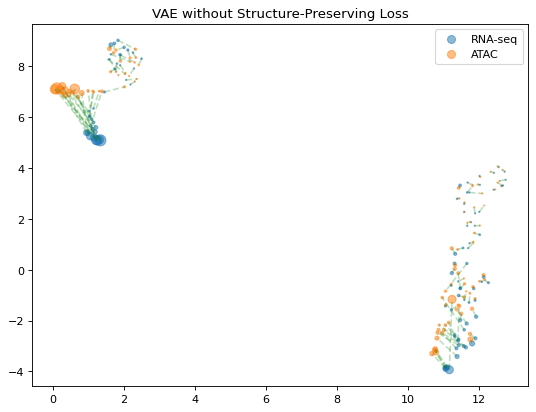

(0.5124522701678444, 0.46626127)

In [34]:
#load checkpoint
checkpoint=None
if path.exists(hyper["checkpoint_path"]):
    checkpoint = torch.load(hyper["checkpoint_path"], map_location="cpu")
netRNA = FC_VAE(n_input=hyper["dimRNA"], nz=hyper["nz"], layer_sizes=hyper["layer_sizes"])
netATAC = FC_VAE(n_input=hyper["dimATAC"], nz=hyper["nz"], layer_sizes=hyper["layer_sizes"])
if checkpoint != None:
    netRNA.load_state_dict(checkpoint["net_rna_state_dict"])
    netATAC.load_state_dict(checkpoint["net_atac_state_dict"])
    
#plot UMAP result and show evaluation metrics value
model_eval(netRNA, netATAC, test_data_filtered, test_data_raw, title="VAE with Structure-Preserving Loss")

In [ ]:
def similairty(netRNA, netATAC, test_data_filtered):
    netRNA.eval()
    netATAC.eval()
    rna_inputs = Variable(torch.from_numpy(test_data_filtered.X.toarray()).float())
    atac_inputs = Variable(torch.from_numpy(test_data_filtered.obsm["mode2"].toarray()).float())
    if torch.cuda.is_available():
        rna_inputs = rna_inputs.cuda()
        atac_inputs = atac_inputs.cuda()
    _, z_rna, _, _ = netRNA(rna_inputs)
    _, z_atac, _, _ = netATAC(atac_inputs)
    cos_score = nn.CosineSimilairty(z_rna, z_atac)
    return(cos_score)